In [1]:
import datajoint as dj
dj.conn().connect()

Please enter DataJoint username: thinh
Please enter DataJoint password: ········
Connecting thinh@mesoscale-activity.datajoint.io:3306


In [9]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy import signal

from pipeline import lab, experiment, ephys, tracking
from pipeline.plot import behavior_plot
%matplotlib inline

In [10]:
import warnings
warnings.filterwarnings('ignore')

# Visualization of behavior and tracking data

This notebook demonstrates data visualization with the MAP pipeline, specifically focus on the queries and visualizations of the behavior and tracking data, using the provided MAP built-in visualization functions

This notebook presents and demonstrates 7 built-in functions - part of the ***behavior_plot*** module:
+ plot_correct_proportion(***session_key***)
+ plot_photostim_effect(***session_key***, ***photostim_key***)

+ plot_tracking(***session_key***, ***unit_key***, ***tracking_feature***, ***camera_key***)
+ plot_unit_jaw_phase_dist(***session_key***, ***unit_key***)
+ plot_trial_tracking(***trial_key***, ***tracking_feature***, ***camera_key***)
+ plot_windowed_jaw_phase_dist(***session_key***)
+ plot_jaw_phase_dist(***session_key***)

***tracking_feature*** are the name of the features available in the tracking schema: `jaw_x`, `jaw_y` (default), `nose_x`, `tongue_y`, `whisker_x`. 

***camera_key*** is the key of the `tracking.TrackingDevice` table, specifying the camera to use the ***tracking_feature*** from, default to the side camera (Camera 0).

#### Let's start by selecting a session of interest

In [48]:
session_key = {'subject_id': 432572, 'session': 15}

# Plot proportional 'correct' for one session

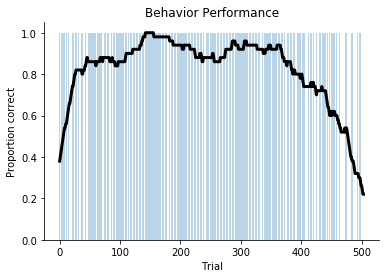

In [15]:
behavior_plot.plot_correct_proportion(session_key);

## Plot proportional 'correct' for multiple sessions

Still make use of the built-in `behavior_plot.plot_correct_proportion()` function. Iterate through all sessions of interest, extract proportional correct output and plot

In [16]:
session_keys = (experiment.Session & {'subject_id': 432572}).fetch('KEY', order_by='session')

In [17]:
p_correct = [behavior_plot.plot_correct_proportion(s, plot=False)[1] for s in session_keys]

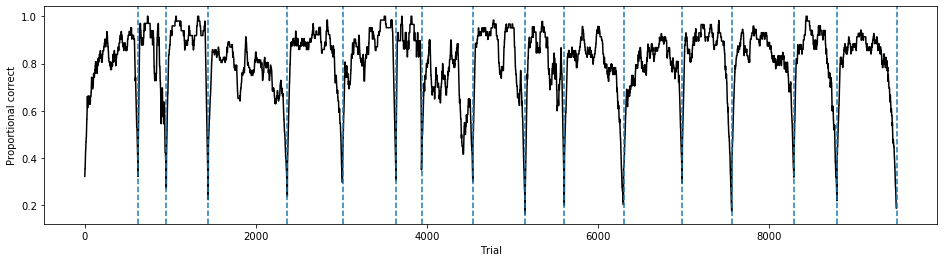

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
ax.plot(np.hstack(p_correct), 'k') 
ax.set_ylabel('Proportional correct')
ax.set_xlabel('Trial')
for s in np.cumsum([len(d) for d in p_correct]):
    ax.axvline(x=s, linestyle='--')

## Plot proportional 'correct' for one session, modulated by photostim

In [21]:
photostims = experiment.Photostim * experiment.PhotostimBrainRegion 

In [23]:
photostims

subject_id institution 6 digit animal ID,session session number,photo_stim photostim protocol number,photostim_device,duration (s),waveform normalized to maximal power. The value of the maximal power is specified for each PhotostimTrialEvent individually,stim_brain_area,stim_laterality
412330,51,4,OBIS470,0.5000,=BLOB=,ALM,left
412330,51,5,OBIS470,0.5000,=BLOB=,ALM,right
412330,51,6,OBIS470,0.5000,=BLOB=,ALM,both
412330,52,4,OBIS470,0.5000,=BLOB=,ALM,left
412330,52,5,OBIS470,0.5000,=BLOB=,ALM,right
412330,52,6,OBIS470,0.5000,=BLOB=,ALM,both
412330,53,4,OBIS470,0.5000,=BLOB=,ALM,left
412330,53,5,OBIS470,0.5000,=BLOB=,ALM,right
412330,53,6,OBIS470,0.5000,=BLOB=,ALM,both
412330,54,4,OBIS470,0.5000,=BLOB=,ALM,left


In [24]:
left_alm_photostim = (photostims & 'stim_brain_area="ALM"' & 'stim_laterality="left"' & session_key).fetch1('KEY')
right_alm_photostim = (photostims & 'stim_brain_area="ALM"' & 'stim_laterality="right"' & session_key).fetch1('KEY')
both_alm_photostim = (photostims & 'stim_brain_area="ALM"' & 'stim_laterality="both"' & session_key).fetch1('KEY')

(None, (0.8109452736318408, 0.8711656441717791), (0.7727272727272727, 0.875))

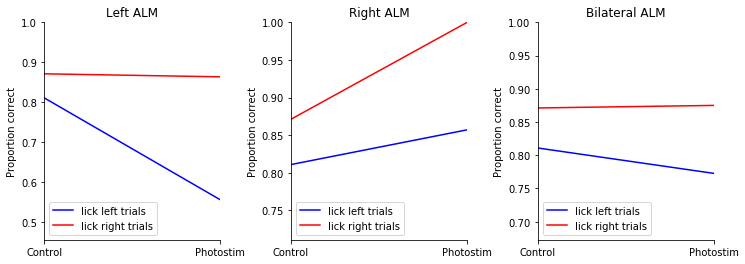

In [25]:
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
fig.subplots_adjust(wspace=0.4)
behavior_plot.plot_photostim_effect(session_key, left_alm_photostim, axs=axs[0], title='Left ALM')
behavior_plot.plot_photostim_effect(session_key, right_alm_photostim, axs=axs[1], title='Right ALM')
behavior_plot.plot_photostim_effect(session_key, both_alm_photostim, axs=axs[2], title='Bilateral ALM')

## Plot proportional 'correct' for multiple sessions, modulated by photostim


Still make use of the built-in `behavior_plot.plot_photostim_effect()` function. Iterate through all sessions of interest, extract proportional correct output and plot

`behavior_plot.plot_photostim_effect()` returns `fig, (cp_ctrl_left, cp_ctrl_right), (cp_stim_left, cp_stim_right)`

In [26]:
# Obtain sessions with photostim - order by session
session_keys = (experiment.Session & {'subject_id': 432572} & experiment.Photostim).fetch('KEY', order_by='session')

In [27]:
photostims = experiment.Photostim * experiment.PhotostimBrainRegion 
left_alm_photostim = (photostims & 'stim_brain_area="ALM"' & 'stim_laterality="left"' & session_keys).fetch('KEY', order_by='session')
right_alm_photostim = (photostims & 'stim_brain_area="ALM"' & 'stim_laterality="right"' & session_keys).fetch('KEY', order_by='session')
both_alm_photostim = (photostims & 'stim_brain_area="ALM"' & 'stim_laterality="both"' & session_keys).fetch('KEY', order_by='session')

In [28]:
# left ALM photostim
leftALM_pcorrect = []
for sess, pstim in zip(session_keys, left_alm_photostim):
    _, (cp_ctrl_left, cp_ctrl_right), (cp_stim_left, cp_stim_right) = behavior_plot.plot_photostim_effect(
        sess, pstim, plot=False)
    leftALM_pcorrect.append([cp_ctrl_left, cp_ctrl_right, cp_stim_left, cp_stim_right])
    
leftALM_pcorrect = np.vstack(leftALM_pcorrect).T

Text(0.5, 0, 'Session')

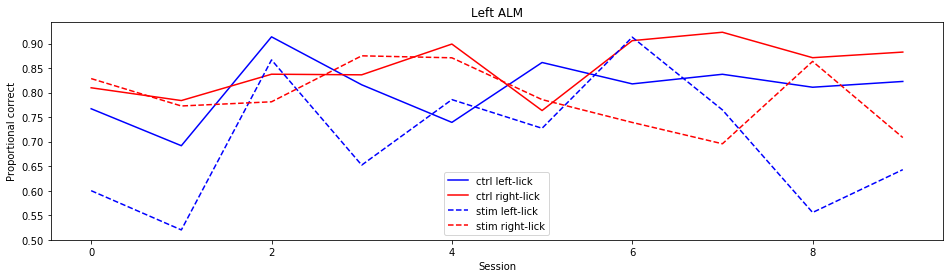

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for d, color, style, label in zip(leftALM_pcorrect,
                                  ('b', 'r', 'b', 'r'),
                                  ('-', '-','--', '--'),
                                  ('ctrl left-lick', 'ctrl right-lick', 'stim left-lick', 'stim right-lick')):
    ax.plot(d, color=color, linestyle=style, label=label)
ax.legend()
ax.set_title('Left ALM')
ax.set_ylabel('Proportional correct')
ax.set_xlabel('Session')

In [30]:
# Right ALM photostim
rightALM_pcorrect = []
for sess, pstim in zip(session_keys, right_alm_photostim):
    _, (cp_ctrl_left, cp_ctrl_right), (cp_stim_left, cp_stim_right) = behavior_plot.plot_photostim_effect(
        sess, pstim, plot=False)
    rightALM_pcorrect.append([cp_ctrl_left, cp_ctrl_right, cp_stim_left, cp_stim_right])
    
rightALM_pcorrect = np.vstack(rightALM_pcorrect).T

Text(0.5, 0, 'Session')

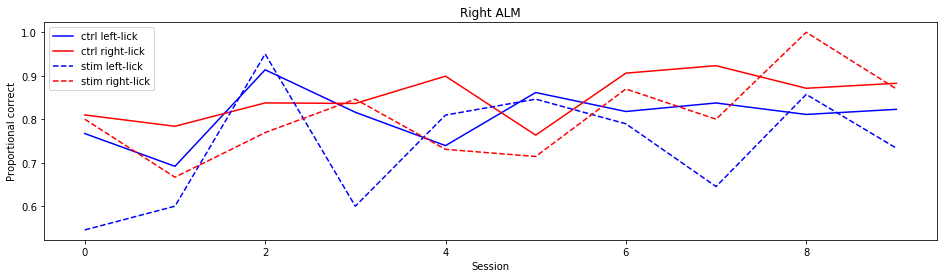

In [31]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for d, color, style, label in zip(rightALM_pcorrect,
                                  ('b', 'r', 'b', 'r'),
                                  ('-', '-','--', '--'),
                                  ('ctrl left-lick', 'ctrl right-lick', 'stim left-lick', 'stim right-lick')):
    ax.plot(d, color=color, linestyle=style, label=label)
ax.legend()
ax.set_title('Right ALM')
ax.set_ylabel('Proportional correct')
ax.set_xlabel('Session')

In [32]:
# Bilateral ALM photostim
bilateralALM_pcorrect = []
for sess, pstim in zip(session_keys, both_alm_photostim):
    _, (cp_ctrl_left, cp_ctrl_right), (cp_stim_left, cp_stim_right) = behavior_plot.plot_photostim_effect(
        sess, pstim, plot=False)
    bilateralALM_pcorrect.append([cp_ctrl_left, cp_ctrl_right, cp_stim_left, cp_stim_right])
    
bilateralALM_pcorrect = np.vstack(bilateralALM_pcorrect).T

Text(0.5, 0, 'Session')

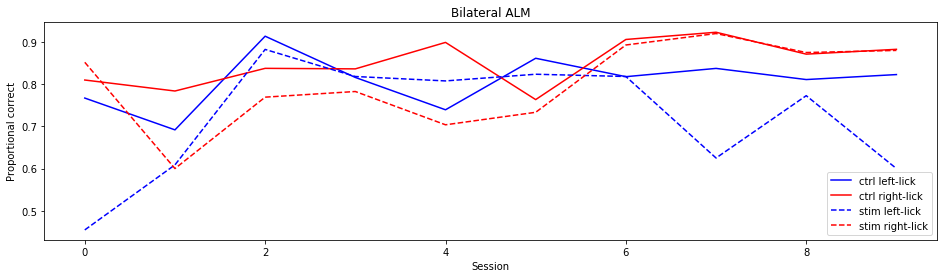

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(16, 4))
for d, color, style, label in zip(bilateralALM_pcorrect,
                                  ('b', 'r', 'b', 'r'),
                                  ('-', '-','--', '--'),
                                  ('ctrl left-lick', 'ctrl right-lick', 'stim left-lick', 'stim right-lick')):
    ax.plot(d, color=color, linestyle=style, label=label)
ax.legend()
ax.set_title('Bilateral ALM')
ax.set_ylabel('Proportional correct')
ax.set_xlabel('Session')

## Plot movement tracking with spiking overlay

In [34]:
ephys.Unit & session_key & 'unit_quality != "all"'

subject_id institution 6 digit animal ID,session session number,insertion_number,clustering_method,unit,unit_uid unique across sessions/animals,unit_quality,probe_type e.g. neuropixels_1.0,electrode_config_name user friendly name,electrode_group electrode group,"electrode electrode index, starts at 0","unit_posx (um) estimated x position of the unit relative to probe's tip (0,0)","unit_posy (um) estimated y position of the unit relative to probe's tip (0,0)",spike_times (s) from the start of the first data point used in clustering,unit_amp,unit_snr,waveform average spike waveform
432572,15,1,jrclust_v3,2,2,good,neuropixels 1.0 - 3A,1-384,0,1,16.495502471923828,2.9200849533081055,=BLOB=,348.4814,19.617632,=BLOB=
432572,15,1,jrclust_v3,3,3,good,neuropixels 1.0 - 3A,1-384,0,4,33.45402526855469,14.26748275756836,=BLOB=,224.59451,14.602229,=BLOB=
432572,15,1,jrclust_v3,15,15,good,neuropixels 1.0 - 3A,1-384,0,10,44.84944152832031,80.28626251220703,=BLOB=,218.74455,14.271657,=BLOB=
432572,15,1,jrclust_v3,16,16,good,neuropixels 1.0 - 3A,1-384,0,10,42.82568359375,80.13217163085938,=BLOB=,141.39143,9.339225,=BLOB=
432572,15,1,jrclust_v3,19,19,good,neuropixels 1.0 - 3A,1-384,0,11,1.8509048223495483,102.2591552734375,=BLOB=,247.92897,16.251682,=BLOB=
432572,15,1,jrclust_v3,25,25,good,neuropixels 1.0 - 3A,1-384,0,14,44.66130828857422,123.09004211425781,=BLOB=,129.26016,8.2028055,=BLOB=
432572,15,1,jrclust_v3,27,27,good,neuropixels 1.0 - 3A,1-384,0,15,6.340969085693359,136.26344299316406,=BLOB=,161.1375,10.288025,=BLOB=
432572,15,1,jrclust_v3,28,28,good,neuropixels 1.0 - 3A,1-384,0,15,1.5163960456848145,140.39697265625,=BLOB=,224.31406,14.959752,=BLOB=
432572,15,1,jrclust_v3,29,29,good,neuropixels 1.0 - 3A,1-384,0,17,16.835664749145508,160.7047882080078,=BLOB=,451.52582,22.30996,=BLOB=
432572,15,1,jrclust_v3,31,31,good,neuropixels 1.0 - 3A,1-384,0,20,31.728797912597656,179.8109130859375,=BLOB=,171.44061,5.748251,=BLOB=


In [46]:
unit_key = (ephys.Unit & session_key & 'unit_quality = "good"' & 'insertion_number=2' & 'unit=1').fetch1('KEY')

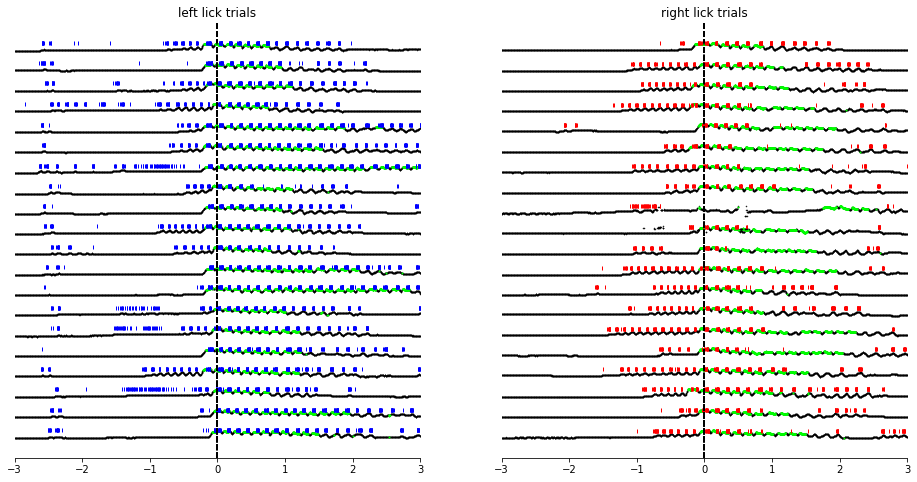

In [47]:
behavior_plot.plot_tracking(session_key, unit_key, xlim=(-3, 3), trial_offset=10, trial_limit=20);

In [37]:
unit_key = (ephys.Unit & session_key & 'unit_quality != "all"' & 'insertion_number=2' & 'unit=1').fetch1('KEY')

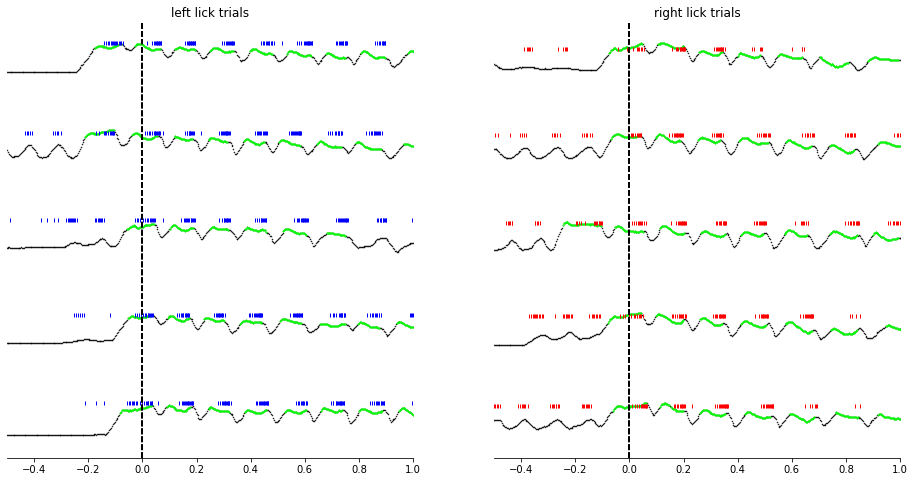

In [38]:
fig, axs = plt.subplots(1, 2, figsize=(16, 8))
behavior_plot.plot_tracking(session_key, unit_key, xlim=(-0.5, 1), trial_offset=10, trial_limit=5, axs=axs)

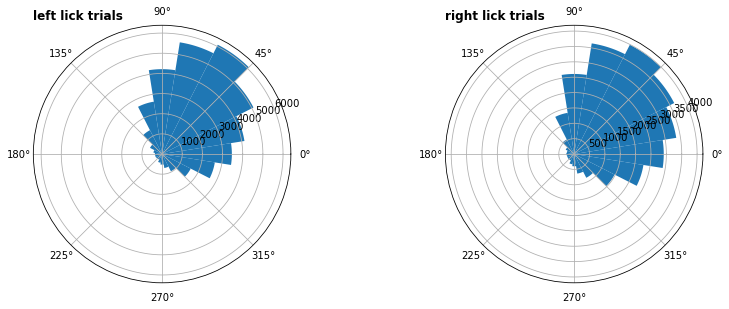

In [40]:
behavior_plot.plot_unit_jaw_phase_dist(session_key, unit_key);

## Plot single-trial jaw movement

In [41]:
trials = tracking.Tracking * experiment.BehaviorTrial & session_key & experiment.TrialEvent

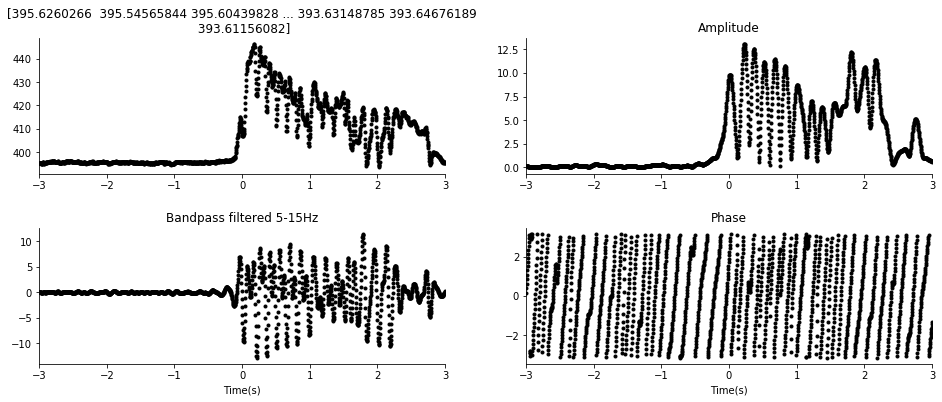

In [43]:
behavior_plot.plot_trial_tracking((trials & f'trial = 100').fetch1('KEY'));

## Plot sliding-window phase distribution of jaw movement

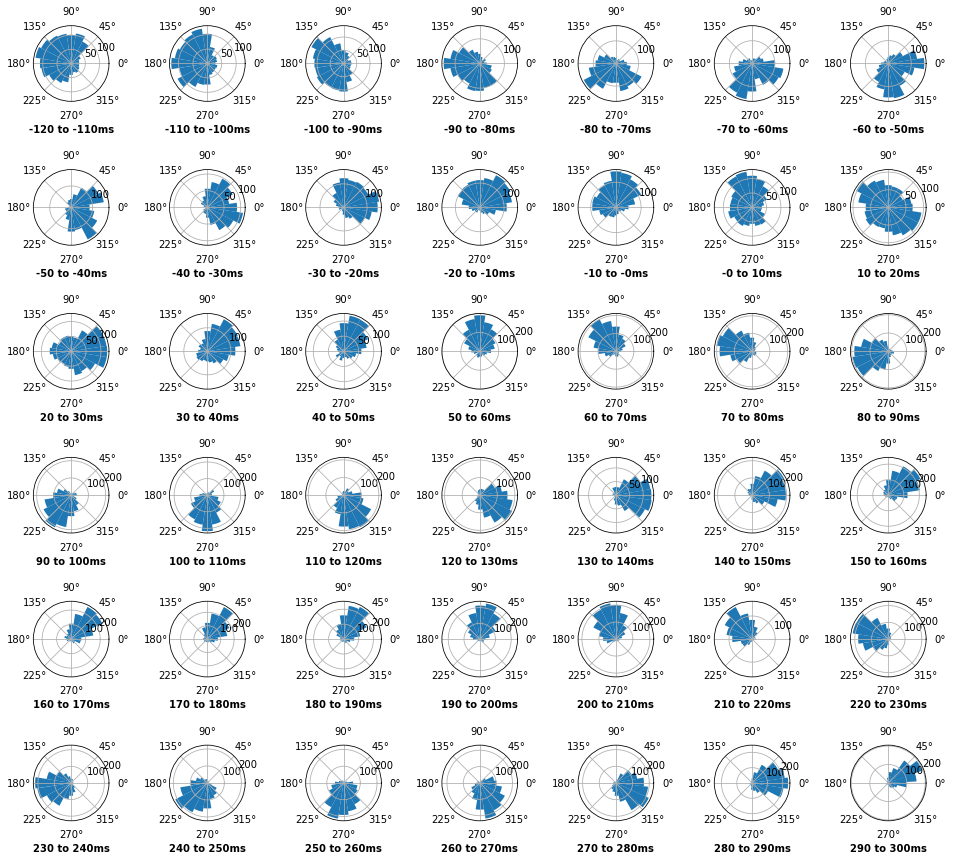

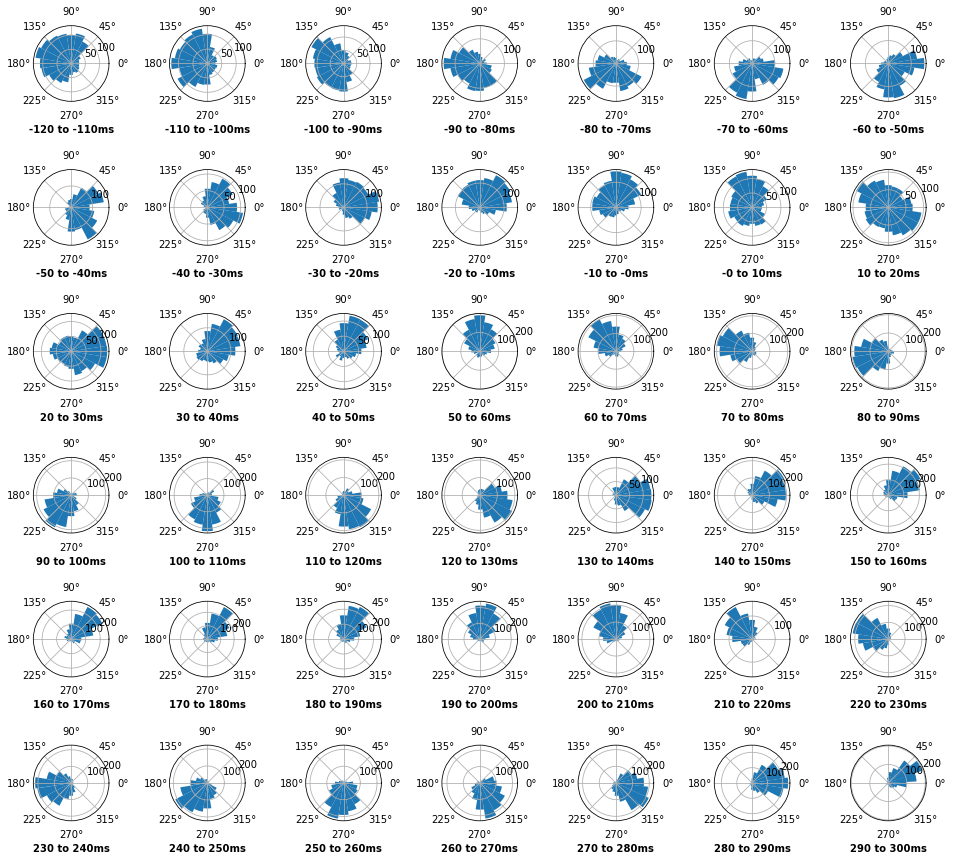

In [44]:
behavior_plot.plot_windowed_jaw_phase_dist(session_key, xlim=(-0.12, 0.3), w_size=0.01, bin_counts=20)

## Plot all phase distribution of jaw movement

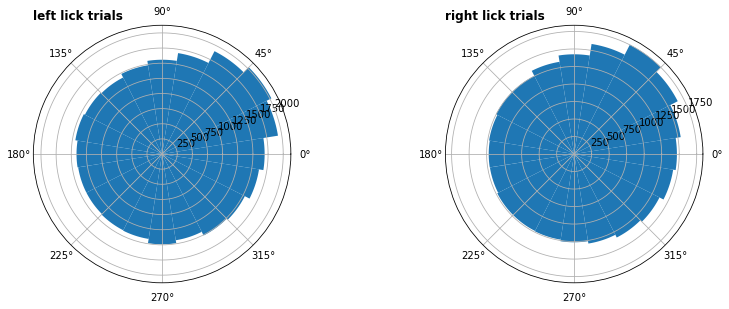

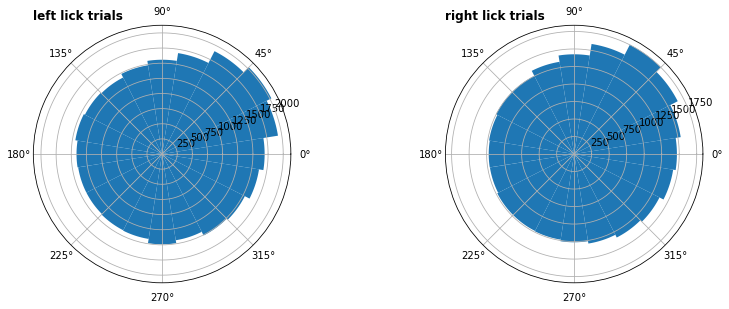

In [45]:
behavior_plot.plot_jaw_phase_dist(session_key, xlim=(-0.12, 0.3), bin_counts=20)